# Prepare Text

In [1]:
import pandas as pd
import numpy as np
import glob
import ast

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
df_el = pd.read_csv('cleaning/Indonesia/2018-09-12 - Consolidated Entity Data - Indonesia.csv')

C:\Users\admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,3,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,27,28,29,30,31,32,33,34,35,37,38,42,43,44,45,46,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,75,76,78,79,80,81,82,83,84,86,87,88,89,90,91,93,94,95,96,97,98,99,100,101,104,105,106,107,108,109,111,112,113,114,115,116,119,120,121,122,123,124,125,126,127,128,142,143,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
text_headers_list = list(pd.read_csv('cleaning/Indonesia/text-headers.csv').columns)

In [21]:
df_el = df_el[text_headers_list]

In [39]:
df_el['text_concat'] = df_el[text_headers_list[2:]].replace(np.nan, "").astype(str).apply(lambda x: ' '.join(x).strip(), axis=1)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
df_el_text = df_el[(df_el['text_concat'] != '') & (df_el['entity_type'].isin(['company', 'startup']))].reset_index(drop=True)

In [58]:
df_el_text['text_concat_len'] = df_el_text['text_concat'].apply(lambda x: len(x))

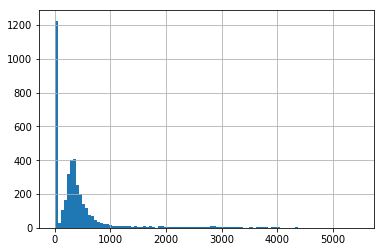

In [59]:
df_el_text['text_concat_len'].hist(bins=100)

In [62]:
df_el_text.head()

,entity_name,entity_type,entity_company,entity_desc,entity_desc_business_model,entity_desc_cohort_based,entity_desc_cohort_info,entity_desc_comment,entity_desc_cvc,entity_desc_details,...,entity_desc_product,entity_desc_stock_index,entity_desc_why,entity_industry,entity_industry_description,entity_industry_list,entity_industry_naics_sector,entity_industry_subtype,text_concat,text_concat_len
0,VALUKLIK PT,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Big data & AI,NaN,NaN,NaN,NaN,Big data & AI,13
1,MEDIATRAC SISTEM KOMUNIKASI / DATTABOT,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Big data & AI,NaN,NaN,NaN,NaN,Big data & AI,13
2,TERADATA,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Big data & AI,NaN,NaN,NaN,NaN,Big data & AI,13
3,ARIM TECHNOLOGIES PTE. LTD.,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Big data & AI,NaN,NaN,NaN,NaN,Big data & AI,13
4,TELKOM INDONESIA,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Big data & AI,NaN,NaN,NaN,NaN,Big data & AI,13


# NLP processing

## Load modules, packages, functions

In [63]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

In [64]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [65]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
# nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [66]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [67]:
for w in ['dogs', 'ran', 'discouraged']:
    print(w, get_lemma(w), get_lemma2(w))

dogs dog dog
ran run ran
discouraged discourage discouraged


In [68]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [69]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

## Process text

In [71]:
data = df_el_text['text_concat'].tolist()

In [72]:
import random
text_data = []

for line in data:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        print(tokens)
    text_data.append(tokens)

['internet', 'service', 'provider']
['internet', 'service', 'provider']
['internet', 'service', 'provider']
['marketing', 'medium']
['fintech']
['arthavest', 'indonesian', 'investment', 'company', 'company', 'list', 'share', 'stock', 'exchange', 'subsidiary', 'sanggraha', 'arthavest', 'involve', 'hospitality', 'industry', 'finance', 'investment', 'joint', 'venture']
['mayora', 'indah', 'indonesia', 'base', 'publicly', 'trade', 'company', 'primarily', 'engage', 'manufacturing', 'industry', 'company', 'product', 'include', 'biscuit', 'candy', 'wafer', 'chocolate', 'instant', 'coffee', 'cereal', 'drink', 'market', 'brand', 'kopiko', 'choki', 'choki', 'torabika', 'energen', 'mayora', 'indah', 'parent', 'company', 'sinar', 'pangan', 'barat', 'sinar', 'pangan', 'timur', 'mayora', 'nederland', 'torabika', 'semesta', 'manufacturing', 'joint', 'venture', 'technology', 'transfer', 'export']
['merdeka', 'copper', 'indonesia', 'base', 'publicly', 'trade', 'company', 'operate', 'holding', 'company'

In [75]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

C:\Users\admin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [76]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [93]:
import pickle
pickle.dump(corpus, open('viz/corpus.pkl', 'wb'))
dictionary.save('viz/dictionary.gensim')

### Try 5 topics

In [88]:
import gensim
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('viz/model%d.gensim' % NUM_TOPICS)

In [89]:
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.118*"indonesia" + 0.073*"services" + 0.066*"jakarta" + 0.061*"startup"')
(1, '0.022*"development" + 0.022*"design" + 0.018*"indonesia" + 0.016*"education"')
(2, '0.062*"online" + 0.026*"store" + 0.022*"health" + 0.018*"product"')
(3, '0.092*"travel" + 0.032*"online" + 0.029*"hotel" + 0.024*"indonesia"')
(4, '0.065*"company" + 0.039*"services" + 0.026*"indonesia" + 0.019*"manufacturing"')
(5, '0.087*"adalah" + 0.049*"informasi" + 0.048*"situs" + 0.047*"host"')
(6, '0.067*"merupakan" + 0.060*"software" + 0.046*"fashion" + 0.030*"perusahaan"')
(7, '0.020*"latest" + 0.014*"indonesia" + 0.012*"creative" + 0.012*"gadget"')
(8, '0.064*"fintech" + 0.032*"medan" + 0.028*"flight" + 0.013*"airline"')
(9, '0.128*"service" + 0.108*"internet" + 0.104*"provider" + 0.040*"game"')
(10, '0.025*"indonesia" + 0.024*"bisnis" + 0.018*"bandung" + 0.017*"cloud"')
(11, '0.030*"online" + 0.024*"untuk" + 0.023*"dengan" + 0.018*"indonesia"')
(12, '0.015*"product" + 0.014*"market" + 0.013*"indonesia" + 0.01

In [ ]:
### new_doc = 'Practical Bayesian Optimization of Machine Learning Algorithms'
# new_doc = prepare_text_for_lda(new_doc)
# new_doc_bow = dictionary.doc2bow(new_doc)
# print(new_doc_bow)
# print(ldamodel.get_document_topics(new_doc_bow))

In [18]:
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
# ldamodel.save('model3.gensim')
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

(0, '0.029*"processor" + 0.016*"management" + 0.016*"aid" + 0.016*"algorithm"')
(1, '0.026*"radio" + 0.026*"network" + 0.026*"cognitive" + 0.026*"efficient"')
(2, '0.029*"circuit" + 0.029*"distribute" + 0.016*"database" + 0.016*"management"')


In [19]:
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
# ldamodel.save('model10.gensim')
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

(0, '0.055*"database" + 0.055*"system" + 0.029*"technical" + 0.029*"recursive"')
(1, '0.038*"distribute" + 0.038*"graphics" + 0.038*"regenerate" + 0.038*"exact"')
(2, '0.055*"management" + 0.029*"multiversion" + 0.029*"reference" + 0.029*"document"')
(3, '0.046*"circuit" + 0.046*"object" + 0.046*"generation" + 0.046*"transformation"')
(4, '0.008*"programming" + 0.008*"circuit" + 0.008*"network" + 0.008*"surface"')
(5, '0.061*"radio" + 0.061*"cognitive" + 0.061*"network" + 0.061*"connectivity"')
(6, '0.085*"programming" + 0.008*"circuit" + 0.008*"subdivision" + 0.008*"management"')
(7, '0.041*"circuit" + 0.041*"design" + 0.041*"processor" + 0.041*"instruction"')
(8, '0.055*"computer" + 0.029*"efficient" + 0.029*"channel" + 0.029*"cooperation"')
(9, '0.061*"stimulation" + 0.061*"sensor" + 0.061*"retinal" + 0.061*"pixel"')


### pyLDAvis

In [94]:
dictionary = gensim.corpora.Dictionary.load('viz/dictionary.gensim')
corpus = pickle.load(open('viz/corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('viz/model%d.gensim' % NUM_TOPICS)

In [95]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)

C:\Users\admin\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [96]:
pyLDAvis.save_html(lda_display, 'viz/Indonesia - LDAviz.html')

In [24]:
# lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
# lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display3)

/Users/sli/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [25]:
# lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
# lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display10)

/Users/sli/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


## DUMMY streamgraph

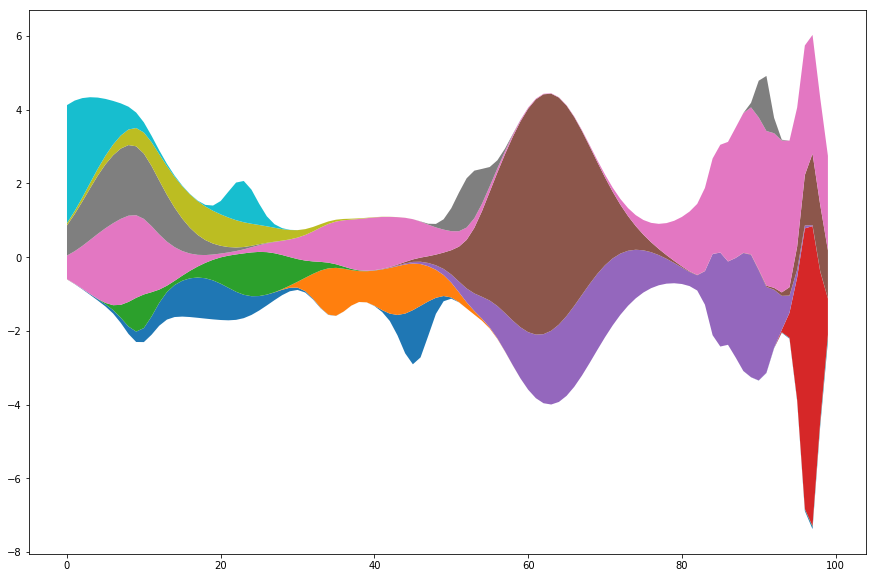

In [2]:
def layers(n, m):
    """
    Return *n* random Gaussian mixtures, each of length *m*.
    """
    def bump(a):
        x = 1 / (.1 + np.random.random())
        y = 2 * np.random.random() - .5
        z = 10 / (.1 + np.random.random())
        for i in range(m):
            w = (i / m - y) * z
            a[i] += x * np.exp(-w * w)
    a = np.zeros((m, n))
    for i in range(n):
        for j in range(5):
            bump(a[:, i])
    return a


d = layers(10, 100)

fig, ax = plt.subplots(figsize=(15,10))
ax.stackplot(range(100), d.T, baseline='wiggle')
plt.show()